In [65]:
import sys
src_path = "../src/"
if src_path not in sys.path:
    sys.path.append(src_path)

from helpers_module import helpers as hlp


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt


from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer, MissingIndicator

import xgboost as xgb
from xgboost import XGBRegressor, plot_importance
from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error,mean_squared_log_error

pd.options.display.max_columns = None
pd.options.display.max_rows = 30
plt.style.use(style='ggplot')

## Load data

In [66]:
RANDOM_STATE=27

train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv('../data/test.csv')

test_id_col = test_df['Id']
n_train = train_df.shape[0]
n_test = test_df.shape[0]

print(f"Train rows: {n_train}, Test rows: {n_test}")
train_df


Train rows: 1460, Test rows: 1459


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,953,953,GasA,Ex,Y,SBrkr,953,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1999.0,RFn,2,460,TA,TA,Y,0,40,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,119.0,TA,TA,CBlock,Gd,TA,No,ALQ,790,Rec,163,589,1542,GasA,TA,Y,SBrkr,2073,0,0,2073,1,0,2,0,3,1,TA,7,Min1,2,TA,Attchd,1978.0,Unf,2,500,TA,TA,Y,349,0,0,0,0,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,None,0.0,Ex,Gd,Stone,TA,Gd,No,GLQ,275,Unf,0,877,1152,GasA,Ex,Y,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,Gd,Attchd,1941.0,RFn,1,252,TA,TA,Y,0,60,0,0,0,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1950,1996,Hip,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,TA,TA,Mn,GLQ,49,Rec,1029,0,1078,Gas

## Common preprocessing

In [67]:
# drop train rows without target value
train_df.dropna(subset = ['SalePrice'], inplace=True)

# keep target column from train and keep it in variable
target = train_df['SalePrice']
train_df.drop(columns=['SalePrice'], inplace=True)

# Concat train and test to common prepearing 
union_df = pd.concat([train_df, test_df]).reset_index(drop=True)

## Prepearing data


### Hard drop id column

In [68]:
union_df = union_df.drop('Id', axis=1)

### Check missing values

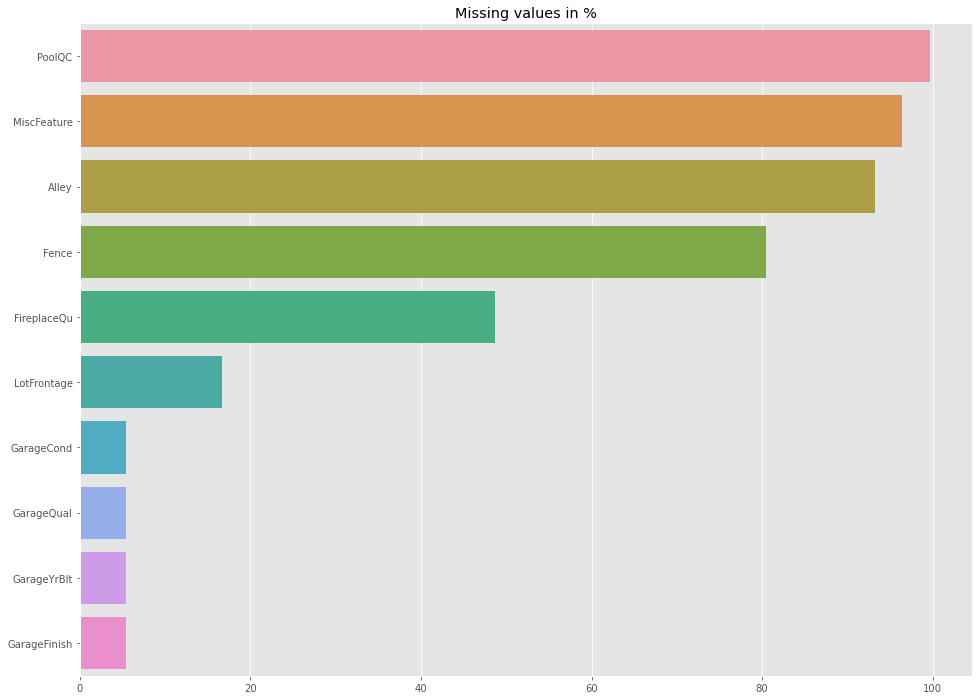

In [69]:
def print_missing_values(df):
    data = df.isna().sum().sort_values(ascending=False) / df.shape[0] * 100
    data = data.head(10)

    plt.figure(figsize=(16,12))
    ax = sns.barplot(y=data.index, x=data.values)
    ax.set_title("Missing values in %")
    
print_missing_values(union_df)

### Check unique values in categorical

In [70]:
df = hlp.get_unique_values_by_columns(union_df) 
df.head(20)

,nunique,unique
Column,,
Neighborhood,25,"[CollgCr, Veenker, Crawfor, NoRidge, Mitchel, ..."
Exterior2nd,16,"[VinylSd, MetalSd, Wd Shng, HdBoard, Plywood, ..."
Exterior1st,15,"[VinylSd, MetalSd, Wd Sdng, HdBoard, BrkFace, ..."
SaleType,9,"[WD, New, COD, ConLD, ConLI, CWD, ConLw, Con, ..."
Condition1,9,"[Norm, Feedr, PosN, Artery, RRAe, RRNn, RRAn, ..."
Condition2,8,"[Norm, Artery, RRNn, Feedr, PosN, PosA, RRAn, ..."
HouseStyle,8,"[2Story, 1Story, 1.5Fin, 1.5Unf, SFoyer, SLvl,..."
RoofMatl,8,"[CompShg, WdShngl, Metal, WdShake, Membran, Ta..."
Functional,7,"[Typ, Min1, Maj1, Min2, Mod, Maj2, Sev, nan]"


### Fill categorical missing values

In [71]:
# fill 'None' in columns where NA mean None (e.g. no basement or garage)
for col in [
        'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
        'FireplaceQu', 
        'GarageFinish', 'GarageType', 'GarageQual', 'GarageCond',
        'Alley', 'PoolQC', 'Fence', 'MiscFeature',
        'MasVnrType'
    ] :

    union_df[col].fillna('None', inplace=True)

    
# fill most frequent
for col in [
        'MSZoning', 'Functional', 'SaleType', 'Exterior2nd', 'Exterior1st', 'KitchenQual', 'Electrical'
    ]:
    
    union_df[col].fillna(union_df[col].mode()[0], inplace=True)


### Fill numerical missing values

In [72]:
for col in [
        "LotFrontage",
        'GarageYrBlt','GarageArea', 'GarageCars',
        'MasVnrArea',
        'BsmtFullBath','BsmtHalfBath','TotalBsmtSF','BsmtUnfSF','BsmtFinSF2', 'BsmtFinSF1'
    ]:
    
    union_df[col].fillna(0, inplace=True)

    
numeric_cols = hlp.get_numeric_cols(union_df)

###  Check missing values again

In [73]:
print("Count of missing values: ", union_df.isna().sum().sum())

Count of missing values:  2


### Fix typos

In [74]:
union_df['MSZoning'].replace(to_replace='C (all)', value='C', inplace=True)

union_df['Neighborhood'].replace(to_replace='NAmes', value='Names', inplace=True)

union_df['BldgType'].replace(to_replace='Twnhs', value='TwnhsI', inplace=True)
union_df['BldgType'].replace(to_replace='Duplex', value='Duplx', inplace=True)
union_df['BldgType'].replace(to_replace='2fmCon', value='2FmCon', inplace=True)

union_df['Exterior2nd'].replace(to_replace='Wd Shng', value='WdShing', inplace=True)
union_df['Exterior2nd'].replace(to_replace='CmentBd', value='CemntBd', inplace=True)
union_df['Exterior2nd'].replace(to_replace='Brk Cmn', value='BrkComm', inplace=True)

### Drop non-infomative columns

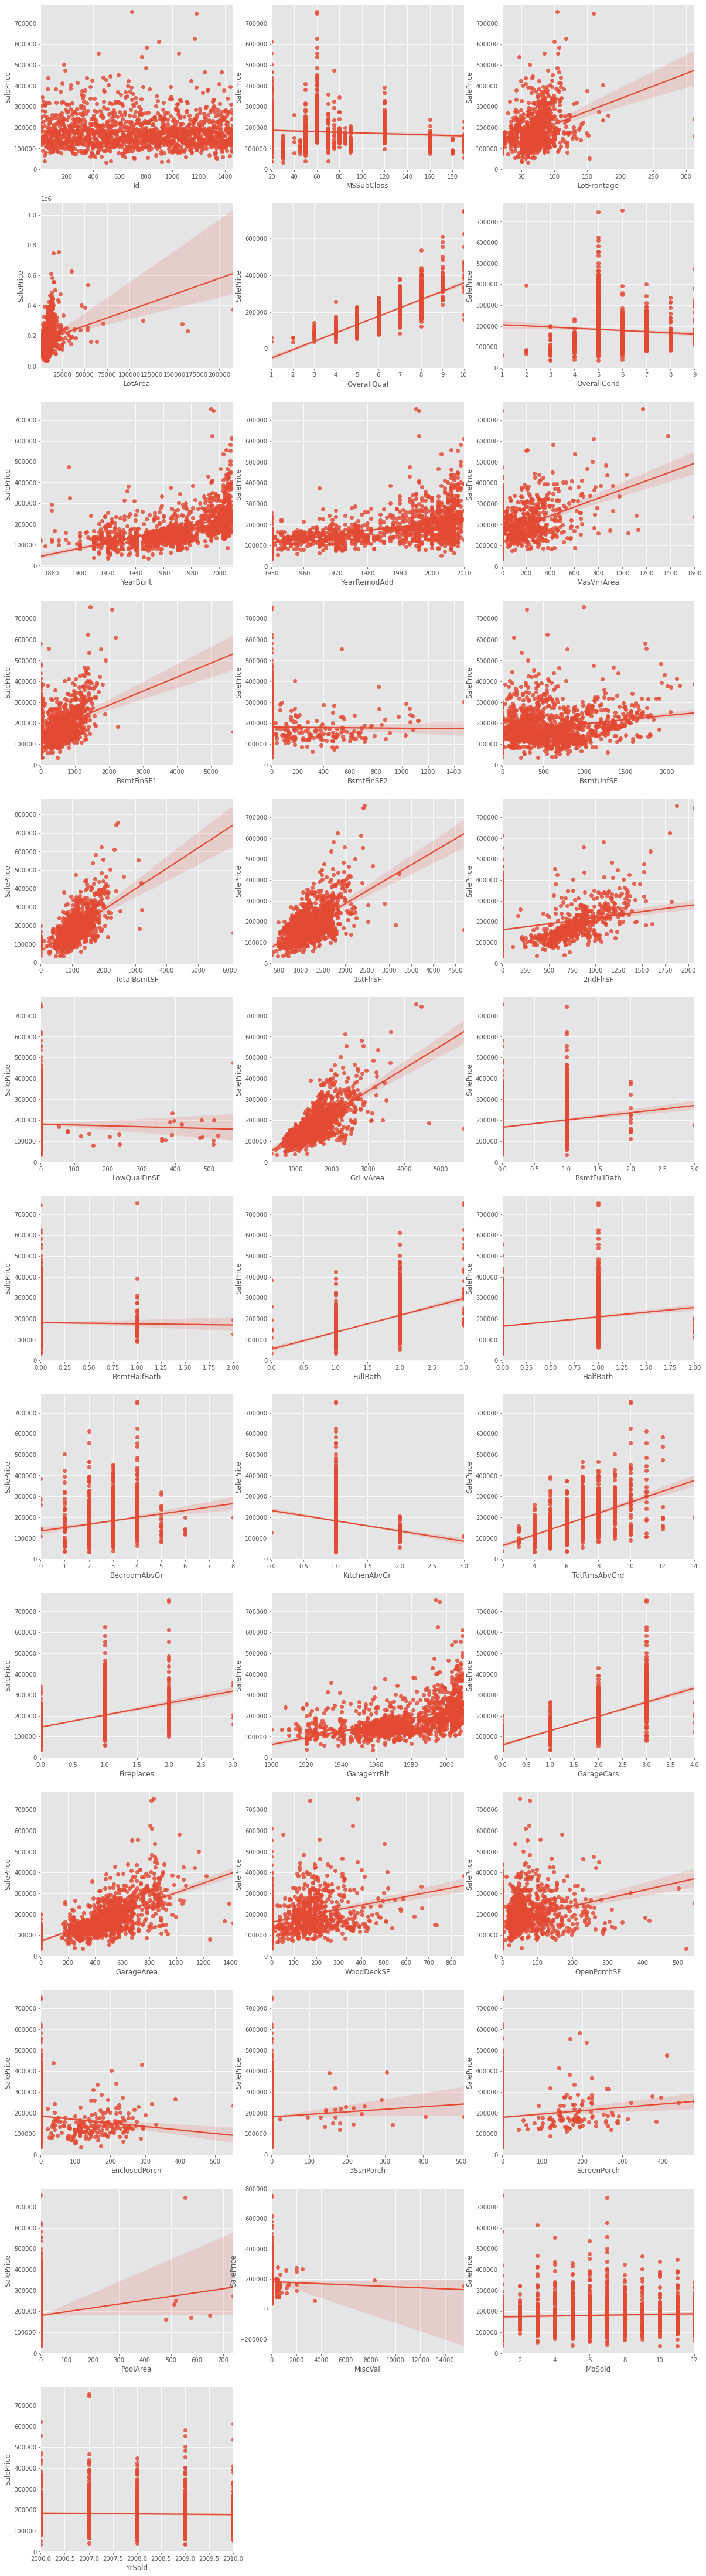

In [75]:
def plot_features_with_target(df, target):
    plt.figure(figsize = (20,80))
    
    for i in enumerate(df._get_numeric_data().columns):
        plt.subplot(13,3,i[0]+1)
        sns.regplot(x=i[1], y=target, data=df)
        plt.xlabel(i[1])
        
plot_features_with_target(train_df, target)

Text(0.5, 1.0, 'PoolQC')

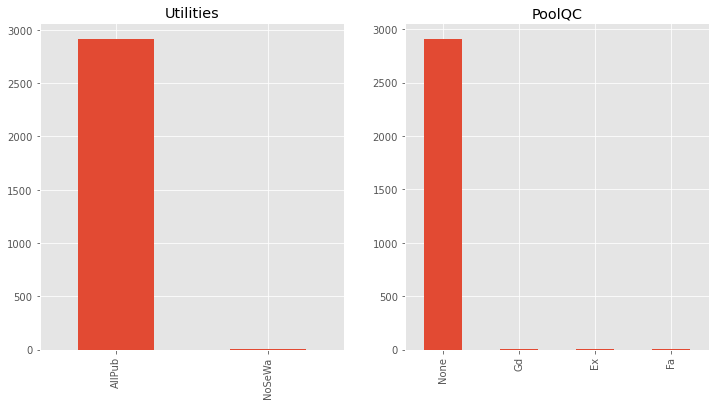

In [76]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
ax = union_df['Utilities'].value_counts().plot(kind='bar')
ax.set_title('Utilities')

plt.subplot(1,2,2)
ax = union_df['PoolQC'].value_counts().plot(kind='bar')
ax.set_title('PoolQC')

In [77]:
# non-informative - just drop
union_df.drop(columns=['Utilities','PoolArea', 'PoolQC', 'YrSold', 'MoSold'], inplace=True)

### Encoding categorical columns

In [78]:
categories_order = {
#     'MSZoning': ['A','C','FV','I','RH','RL','RP','RM'],
    'Street': ['Grvl','Pave'],
    'Alley': ['None','Grvl','Pave'],
    'LotShape': ['Reg','IR1','IR2','IR3'],
#     'LandContour': ['Lvl','Bnk','HLS','Low'],
#     'LotConfig': ['Inside','Corner','CulDSac','FR2','FR3'],
    'LandSlope': ['Gtl','Mod','Sev'],
#     'Neighborhood': ['Blmngtn','Blueste','BrDale','BrkSide','ClearCr','CollgCr','Crawfor','Edwards','Gilbert','IDOTRR','MeadowV','Mitchel','Names','NoRidge','NPkVill','NridgHt','NWAmes','OldTown','SWISU','Sawyer','SawyerW','Somerst','StoneBr','Timber','Veenker'],
#     'Condition1': ['Artery','Feedr','Norm','RRNn','RRAn','PosN','PosA','RRNe','RRAe'],
#     'Condition2': ['Artery','Feedr','Norm','RRNn','RRAn','PosN','PosA','RRNe','RRAe'],
    'BldgType': ['1Fam','2FmCon','Duplx','TwnhsE','TwnhsI'],
    'HouseStyle': ['SFoyer','SLvl','1Story','1.5Unf','1.5Fin','2Story','2.5Unf','2.5Fin'],
#     'RoofStyle': ['Flat','Gable','Gambrel','Hip','Mansard','Shed'],
#     'RoofMatl': ['ClyTile','CompShg','Membran','Metal','Roll','Tar&Grv','WdShake','WdShngl'],
#     'Exterior1st': ['AsbShng','AsphShn','BrkComm','BrkFace','CBlock','CemntBd','HdBoard','ImStucc','MetalSd','Other','Plywood','PreCast','Stone','Stucco','VinylSd','Wd Sdng','WdShing'],
#     'Exterior2nd': ['AsbShng','AsphShn','BrkComm','BrkFace','CBlock','CemntBd','HdBoard','ImStucc','MetalSd','Other','Plywood','PreCast','Stone','Stucco','VinylSd','Wd Sdng','WdShing'],
#     'MasVnrType': ['BrkCmn','BrkFace','CBlock','None','Stone'],
    'ExterQual': ['Ex','Gd','TA','Fa','Po'],
    'ExterCond': ['Ex','Gd','TA','Fa','Po'],
#     'Foundation': ['BrkTil','CBlock','PConc','Slab','Stone','Wood'],
    'BsmtQual': ['Ex','Gd','TA','Fa','Po','None'],
    'BsmtCond': ['Ex','Gd','TA','Fa','Po','None'],
    'BsmtExposure': ['Gd','Av','Mn','No','None'],
    'BsmtFinType1': ['GLQ','ALQ','BLQ','Rec','LwQ','Unf','None'],
    'BsmtFinType2': ['GLQ','ALQ','BLQ','Rec','LwQ','Unf','None'],
#     'Heating': ['Floor','GasA','GasW','Grav','OthW','Wall'],
    'HeatingQC': ['Ex','Gd','TA','Fa','Po'],
    'CentralAir': ['N','Y'],
#     'Electrical': ['SBrkr','FuseA','FuseF','FuseP','Mix'],
    'KitchenQual': ['Ex','Gd','TA','Fa','Po'],
    'Functional': ['Typ','Min1','Min2','Mod','Maj1','Maj2','Sev','Sal'],
    'FireplaceQu': ['Ex','Gd','TA','Fa','Po','None'],
    'GarageType': ['2Types','Attchd','Basment','BuiltIn','CarPort','Detchd','None'],
    'GarageFinish': ['Fin','RFn','Unf','None'],
    'GarageQual': ['Ex','Gd','TA','Fa','Po','None'],
    'GarageCond': ['Ex','Gd','TA','Fa','Po','None'],
    'PavedDrive': ['Y','P','N'],
    'PoolQC': ['Ex','Gd','TA','Fa','None'],
    'Fence': ['GdPrv','MnPrv','GdWo','MnWw','None'],
#     'MiscFeature': ['Elev','Gar2','Othr','Shed','TenC','None'],
#     'SaleType': ['WD','CWD','VWD','New','COD','Con','ConLw','ConLI','ConLD','Oth'],
#     'SaleCondition': ['Normal','Abnorml','AdjLand','Alloca','Family','Partial'],    
}

In [79]:
cat=5

# 1. Just drop all categorial columns
if cat == 1:
    union_df = hlp.drop_str_cols(union_df)

# ------ OR ------

# 2. Encode by simple labels
if cat == 2:
    union_df = hlp.encode_with_labels(union_df)

# ------ OR ------

# 3. Encode by one hot
if cat == 3:
    union_df = hlp.encode_with_one_hot(union_df)

# 4. Encode by simple labels with order
if cat == 4:
    df = union_df
    
    encoded_df = df.copy()
    
    for col in hlp.get_str_cols(df):
        if categories_order.get(col) != None:
            encoder = OrdinalEncoder(categories=[categories_order[col]])
        else:
            encoder = OrdinalEncoder(categories='auto')
            
        encoded_df[col] = encoder.fit_transform(df[col].values.reshape(-1, 1)).astype('int')

    union_df = encoded_df

# 5. Mixed encoding - use simple labels for columns in categories_order and one hot for others
if cat == 5:
    df = union_df
    
    encoded_df = df.copy()
    
    for col in df.columns:
        if categories_order.get(col) != None:
            encoder = OrdinalEncoder(categories=[categories_order[col]])            
            encoded_df[col] = encoder.fit_transform(df[col].values.reshape(-1, 1)).astype('int')

    union_df = hlp.encode_with_one_hot(encoded_df)


In [80]:
union_df

,MSSubClass,LotFrontage,LotArea,Street,Alley,LotShape,LandSlope,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,Fence,MiscVal,MSZoning_0,MSZoning_1,MSZoning_2,MSZoning_3,MSZoning_4,LandContour_0,LandContour_1,LandContour_2,LandContour_3,LotConfig_0,LotConfig_1,LotConfig_2,LotConfig_3,LotConfig_4,Neighborhood_0,Neighborhood_1,Neighborhood_2,Neighborhood_3,Neighborhood_4,Neighborhood_5,Neighborhood_6,Neighborhood_7,Neighborhood_8,Neighborhood_9,Neighborhood_10,Neighborhood_11,Neighborhood_12,Neighborhood_13,Neighborhood_14,Neighborhood_15,Neighborhood_16,Neighborhood_17,Neighborhood_18,Neighborhood_19,Neighborhood_20,Neighborhood_21,Neighborhood_22,Neighborhood_23,Neighborhood_24,Condition1_0,Condition1_1,Condition1_2,Condition1_3,Condition1_4,Condition1_5,Condition1_6,Condition1_7,Condition1_8,Condition2_0,Condition2_1,Condition2_2,Condition2_3,Condition2_4,Condition2_5,Condition2_6,Condition2_7,RoofStyle_0,RoofStyle_1,RoofStyle_2,RoofStyle_3,RoofStyle_4,RoofStyle_5,RoofMatl_0,RoofMatl_1,RoofMatl_2,RoofMatl_3,RoofMatl_4,RoofMatl_5,RoofMatl_6,RoofMatl_7,Exterior1st_0,Exterior1st_1,Exterior1st_2,Exterior1st_3,Exterior1st_4,Exterior1st_5,Exterior1st_6,Exterior1st_7,Exterior1st_8,Exterior1st_9,Exterior1st_10,Exterior1st_11,Exterior1st_12,Exterior1st_13,Exterior1st_14,Exterior2nd_0,Exterior2nd_1,Exterior2nd_2,Exterior2nd_3,Exterior2nd_4,Exterior2nd_5,Exterior2nd_6,Exterior2nd_7,Exterior2nd_8,Exterior2nd_9,Exterior2nd_10,Exterior2nd_11,Exterior2nd_12,Exterior2nd_13,Exterior2nd_14,Exterior2nd_15,MasVnrType_0,MasVnrType_1,MasVnrType_2,MasVnrType_3,Foundation_0,Foundation_1,Foundation_2,Foundation_3,Foundation_4,Foundation_5,Heating_0,Heating_1,Heating_2,Heating_3,Heating_4,Heating_5,Electrical_0,Electrical_1,Electrical_2,Electrical_3,Electrical_4,MiscFeature_0,MiscFeature_1,MiscFeature_2,MiscFeature_3,MiscFeature_4,SaleType_0,SaleType_1,SaleType_2,SaleType_3,SaleType_4,SaleType_5,SaleType_6,SaleType_7,SaleType_8,SaleCondition_0,SaleCondition_1,SaleCondition_2,SaleCondition_3,SaleCondition_4,SaleCondition_5
0,60,65.0,8450,1,0,0,0,0,5,7,5,2003,2003,196.0,1,2,1,2,3,0,706.0,5,0.0,150.0,856.0,0,1,856,854,0,1710,1.0,0.0,2,1,3,1,1,8,0,0,5,1,2003.0,1,2.0,548.0,2,2,0,0,61,0,0,0,4,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,20,80.0,9600,1,0,0,0,0,2,6,8,1976,1976,0.0,2,2,1,2,0,1,978.0,5,0.0,284.0,1262.0,0,1,1262,0,0,1262,0.0,1.0,2,0,3,1,2,6,0,1,2,1,1976.0,1,2.0,460.0,2,2,0,298,0,0,0,0,4,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2,60,68.0,11250,1,0,1,0,0,5,7,5,2001,2002,162.0,1,2,1,2,2,0,486.0,5,0.0,434.0,920.0,0,1,920,866,0,1786,1.0,0.0,2,1,3,1,1,6,0,1,2,1,2001.0,1,2.0,608.0,2,2,0,0,42,0,0,0,4,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
3,70,60.0,9550,1,0,1,0,0,5,7,5,1915,1970,0.0,2,2,2,1,3,1,216.0,5,0.0,540.0,756.0,1,1,961,756,0,1717,1.0,0.0,1,0,3

## Numerical columns processing

In [81]:
# min_max_scaler = MinMaxScaler()
# union_df = min_max_scaler.fit_transform()


## Split data back

In [82]:
train_df = union_df[:n_train]
test_df = union_df[n_train:]

train_df

,MSSubClass,LotFrontage,LotArea,Street,Alley,LotShape,LandSlope,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,Fence,MiscVal,MSZoning_0,MSZoning_1,MSZoning_2,MSZoning_3,MSZoning_4,LandContour_0,LandContour_1,LandContour_2,LandContour_3,LotConfig_0,LotConfig_1,LotConfig_2,LotConfig_3,LotConfig_4,Neighborhood_0,Neighborhood_1,Neighborhood_2,Neighborhood_3,Neighborhood_4,Neighborhood_5,Neighborhood_6,Neighborhood_7,Neighborhood_8,Neighborhood_9,Neighborhood_10,Neighborhood_11,Neighborhood_12,Neighborhood_13,Neighborhood_14,Neighborhood_15,Neighborhood_16,Neighborhood_17,Neighborhood_18,Neighborhood_19,Neighborhood_20,Neighborhood_21,Neighborhood_22,Neighborhood_23,Neighborhood_24,Condition1_0,Condition1_1,Condition1_2,Condition1_3,Condition1_4,Condition1_5,Condition1_6,Condition1_7,Condition1_8,Condition2_0,Condition2_1,Condition2_2,Condition2_3,Condition2_4,Condition2_5,Condition2_6,Condition2_7,RoofStyle_0,RoofStyle_1,RoofStyle_2,RoofStyle_3,RoofStyle_4,RoofStyle_5,RoofMatl_0,RoofMatl_1,RoofMatl_2,RoofMatl_3,RoofMatl_4,RoofMatl_5,RoofMatl_6,RoofMatl_7,Exterior1st_0,Exterior1st_1,Exterior1st_2,Exterior1st_3,Exterior1st_4,Exterior1st_5,Exterior1st_6,Exterior1st_7,Exterior1st_8,Exterior1st_9,Exterior1st_10,Exterior1st_11,Exterior1st_12,Exterior1st_13,Exterior1st_14,Exterior2nd_0,Exterior2nd_1,Exterior2nd_2,Exterior2nd_3,Exterior2nd_4,Exterior2nd_5,Exterior2nd_6,Exterior2nd_7,Exterior2nd_8,Exterior2nd_9,Exterior2nd_10,Exterior2nd_11,Exterior2nd_12,Exterior2nd_13,Exterior2nd_14,Exterior2nd_15,MasVnrType_0,MasVnrType_1,MasVnrType_2,MasVnrType_3,Foundation_0,Foundation_1,Foundation_2,Foundation_3,Foundation_4,Foundation_5,Heating_0,Heating_1,Heating_2,Heating_3,Heating_4,Heating_5,Electrical_0,Electrical_1,Electrical_2,Electrical_3,Electrical_4,MiscFeature_0,MiscFeature_1,MiscFeature_2,MiscFeature_3,MiscFeature_4,SaleType_0,SaleType_1,SaleType_2,SaleType_3,SaleType_4,SaleType_5,SaleType_6,SaleType_7,SaleType_8,SaleCondition_0,SaleCondition_1,SaleCondition_2,SaleCondition_3,SaleCondition_4,SaleCondition_5
0,60,65.0,8450,1,0,0,0,0,5,7,5,2003,2003,196.0,1,2,1,2,3,0,706.0,5,0.0,150.0,856.0,0,1,856,854,0,1710,1.0,0.0,2,1,3,1,1,8,0,0,5,1,2003.0,1,2.0,548.0,2,2,0,0,61,0,0,0,4,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,20,80.0,9600,1,0,0,0,0,2,6,8,1976,1976,0.0,2,2,1,2,0,1,978.0,5,0.0,284.0,1262.0,0,1,1262,0,0,1262,0.0,1.0,2,0,3,1,2,6,0,1,2,1,1976.0,1,2.0,460.0,2,2,0,298,0,0,0,0,4,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2,60,68.0,11250,1,0,1,0,0,5,7,5,2001,2002,162.0,1,2,1,2,2,0,486.0,5,0.0,434.0,920.0,0,1,920,866,0,1786,1.0,0.0,2,1,3,1,1,6,0,1,2,1,2001.0,1,2.0,608.0,2,2,0,0,42,0,0,0,4,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
3,70,60.0,9550,1,0,1,0,0,5,7,5,1915,1970,0.0,2,2,2,1,3,1,216.0,5,0.0,540.0,756.0,1,1,961,756,0,1717,1.0,0.0,1,0,3


## Prepearing for model

### Skew

Prices are right skewed - will use log to normalize

Skew is: 1.8828757597682129


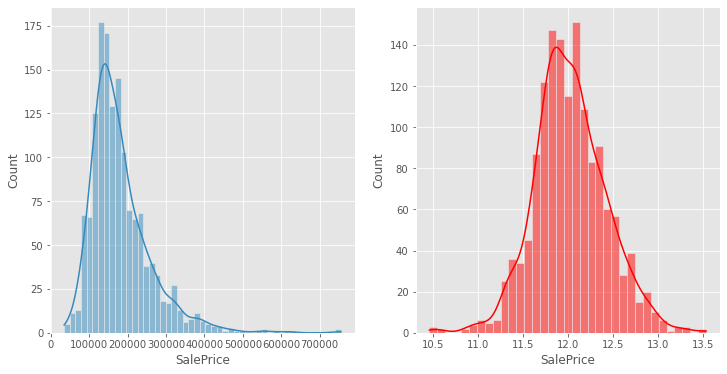

In [83]:
print ("Skew is:", target.skew())

fig, axes = plt.subplots(1,2, figsize=(12,6))

sns.histplot(target, kde=True, ax=axes[0])
sns.histplot(np.log1p(target), kde=True, ax=axes[1], color="red")
plt.show()

### Split data

In [84]:
X = train_df
y = np.log1p(target)

X_test = test_df

X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=RANDOM_STATE)

## Research Model

### Find best hyperparameters for XGBoost

In [85]:
need_find_best_params=False

if need_find_best_params:
    xgb_params = {
        'learning_rate': 0.05, 
        'max_depth': 3, 
        'min_child_weight': 1, 
    }

    param_grid = {
        'base_score': [0.5,0.4],
        'colsample_bytree': [0.3,0.4603],
        'gamma': [0,0.05],
        'min_child_weight': [1,1.7817],
        'reg_alpha': [0,0.464],
        'reg_lambda': [2,0.8571],
        'subsample': [0.5,0.5213],
        
        "n_estimators": [700]
    }


    reserch_model = XGBRegressor(**xgb_params)

    xgb_rscv = GridSearchCV(reserch_model, param_grid = param_grid, 
                                  scoring='neg_mean_squared_error',
                                  n_jobs=4,
                                  cv=5,
                                  verbose = True)

#     model_xgboost = xgb_rscv.fit(X_train, y_train,early_stopping_rounds=200,
#               eval_set=[(X_valid, y_valid)], eval_metric='rmsle', verbose=False)

    model_xgboost = xgb_rscv.fit(X, y, eval_metric='rmse', verbose=False)

    best_params = model_xgboost.best_params_
    print(f"Best score: {model_xgboost.best_score_:.5f} \nBest params: {best_params}")


### Find optimal  n_estimators

In [86]:
xgb_params = {    
    'colsample_bytree': 0.3, 
    'learning_rate': 0.05, 
    'max_depth': 3,
    
    'min_child_weight': 1, 
    'n_estimators': 700, 
    'base_score': 0.5, 
    'reg_lambda': 2, 
    'subsample': 0.5213,
}

need_find_optimal_n_estimators = True

if need_find_optimal_n_estimators:
    reserch_model = XGBRegressor(**xgb_params)

    reserch_model.fit(X_train, y_train, early_stopping_rounds=350, 
              eval_set=[(X_valid, y_valid)], eval_metric='rmse', verbose=False)

    y_train_pred = reserch_model.predict(X_train)
    y_valid_pred = reserch_model.predict(X_valid)

    print("RMSE train: {:.5f}".format(sqrt(mean_squared_error(y_train, y_train_pred))))
    print("RMSE: {:.5f}".format(sqrt(mean_squared_error(y_valid, y_valid_pred))))
    print("R2: {:.5f}".format(r2_score(y_valid, y_valid_pred)))
    print("Best: {:.5f}, iter={:d}".format(reserch_model.best_score, reserch_model.best_iteration))
    
    xgb_params['n_estimators'] = reserch_model.best_iteration
else:
    reserch_model.best_iteration = ""
    

RMSE train: 0.05753
RMSE: 0.12257
R2: 0.90451
Best: 0.12257, iter=612


### Cross score check by rmse and r2

In [87]:
need_make_cross_score=True

if need_make_cross_score: 
#     xgb_params['n_estimators'] = 

    # check by r2 score by cross validation
    model_for_cross_val = XGBRegressor(**xgb_params)

    scores = cross_validate(model_for_cross_val, X, y,
                            n_jobs=4, cv=5,
                            scoring=('r2', 'neg_mean_squared_error'),
                            return_train_score=True)

    rmse = scores['test_neg_mean_squared_error'].mean()

    print("RMSE train mean: {:10.5f}".format(scores['train_neg_mean_squared_error'].mean()))
    print("R2 train mean:   {:10.5f}".format(scores['train_r2'].mean()))
    print("----")
    print("RMSE test mean:  {:10.5f}".format(scores['test_neg_mean_squared_error'].mean()))
    print("R2 test mean:    {:10.5f}".format(scores['test_r2'].mean()))

RMSE train mean:   -0.00358
R2 train mean:      0.97752
----
RMSE test mean:    -0.01432
R2 test mean:       0.91068


## Train model

In [88]:
model_final = XGBRegressor(**xgb_params)
model_final.fit(X, y)

y_train_pred = model_final.predict(X)

print("RMSE train: {:.5f}".format(sqrt(mean_squared_error(y, y_train_pred))))
print("RMSLE train: {:.5f}".format(sqrt(mean_squared_log_error(y, y_train_pred))))
print("R2 train: {:.5f}".format(r2_score(y, y_train_pred)))

RMSE train: 0.06523
RMSLE train: 0.00506
R2 train: 0.97332


## Prediction and save result

In [89]:
def params_to_str(params):
    res = ""
    for k,v in params.items():
        for s in k.split('_'):
            res += s[:2]
        res += str(v)
        res += "_"
        
    return res[:-1]


In [ ]:
y_test_pred = np.expm1(model_final.predict(X_test))

output = pd.DataFrame({'Id': test_id_col, 'SalePrice': y_test_pred})
output.to_csv(f'../data/rmse_{rmse:.5f}_xgb{reserch_model.best_iteration}_r_Id_enc-cat{cat}_logy_{params_to_str(xgb_params)}_2.csv', index=False)